# Polar Coding Functions

Helper Functions and Imports

In [1]:
import numpy as np

def is_power_of_two(n):
    return (n & (n-1)) == 0 and n > 0


def bitrev_premutation(N):
    if N == 1:
        return np.array([0], dtype=int)
    n = int(np.log2(N))
    br = np.empty(N, dtype=int)
    
    for i in range(N):
        b = format(i, '0{}b'.format(n))[::-1]
        br[i] = int(b, 2)
    return br

Channels

In [2]:
def bsc(x, p):
    flips = (np.random.rand(len(x)) < p).astype(np.int8)
    return (x ^ flips).astype(np.int8)


def bsc_llr(y, p, eps=1e-12):
    p_safe = min(max(float(p), eps), 1.0 - eps)
    alpha = np.log((1.0 - p_safe) / p_safe)
    return (1 - 2*y) * alpha

LLR (Log-Likelihood Ratios) Combines

In [3]:
def f_min_sum(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sign(a * b) * np.minimum(np.abs(a), np.abs(b))


def f_exact(a, b, eps=1e-12):
    A = np.array(a, dtype=float)
    B = np.array(b, dtype=float)
    ta = np.tanh(A / 2.0)
    tb = np.tanh(B / 2.0)
    t = ta * tb
    t = np.clip(t, -1.0 + eps, 1.0 - eps)
    return np.log1p(t) - np.log1p(-t)

Channel Polarization Functions

In [4]:
def bhattacharyya_parameter(p, N):
    Z = np.array([2.0 * np.sqrt(p * (1.0 - p))])
    while len(Z) < N:
        Z_next = []
        for z in Z:
            Z_next.append(2*z - z*z)  # Upper
            Z_next.append(z*z) # Lower
        Z = np.array(Z_next)
    return Z


def select_frozen_direct(N, K, p_design):
    # Selects K best channels and creates correct masks for decoder and encoder

    Z = bhattacharyya_parameter(p_design, N)
    logical_best = np.argsort(Z)[:K]

    # Map logical indices to bit-reversed/canonical indices
    br = bitrev_premutation(N) # br[natural] = logical
    inv_br = np.argsort(br) # inv_br[logical] = natural

    info_positions_canonical = np.sort(logical_best)

    # Map canonical info positions to natural order for encoder
    info_positions_natural = np.sort(inv_br[info_positions_canonical])

    # Build natural frozen mask for encoder
    frozen_mask_natural = np.ones(N, dtype=bool)
    frozen_mask_natural[info_positions_natural] = False

    # Build canonical frozen mask for decoder
    frozen_mask_canonical = np.ones(N, dtype=bool)
    frozen_mask_canonical[info_positions_canonical] = False

    return (frozen_mask_natural, info_positions_natural,
            frozen_mask_canonical, info_positions_canonical)

Encoding and Decoding Functions

In [5]:
def polar_encode(u):
    u = np.asarray(u, dtype=int)
    N = len(u)
    if N == 1:
        return u.copy().astype(np.int8)
    
    # Split even/odd positions as per natural-order recursive definition
    u_even = u[0:N:2]
    u_odd = u[1:N:2]
    upper = polar_encode((u_even ^ u_odd) % 2)
    lower = polar_encode(u_odd)

    return np.concatenate([upper, lower]).astype(np.int8)


def sc_decode(llr, frozen_mask, u_frozen=None, use_exact_f=False):
    # Returns uhat in canonical order (SC leaf order)
    
    if u_frozen is None:
        u_frozen = np.zeros(len(frozen_mask), dtype=np.int8)
    
    llr = np.array(llr, dtype=float)
    frozen_mask = np.array(frozen_mask, dtype=bool)
    u_frozen = np.array(u_frozen, dtype=np.int8)

    def rec(llr_sub, frozen_sub, u_frozen_sub):
        n = len(llr_sub)
        if n == 1:
            if frozen_sub[0]:
                return np.array([u_frozen_sub[0]], dtype=np.int8)
            else:
                return np.array([0 if llr_sub[0] >= 0 else 1], dtype=np.int8)
        n_half = n // 2
        a = llr_sub[:n_half]
        b = llr_sub[n_half:]
        f_llr = f_exact(a, b) if use_exact_f else f_min_sum(a, b)
        uhat_up = rec(f_llr, frozen_sub[:n_half], u_frozen_sub[:n_half])
        g_llr = b + ((-1) ** uhat_up) * a
        uhat_low = rec(g_llr, frozen_sub[n_half:], u_frozen_sub[n_half:])
        u_upper = (uhat_up ^ uhat_low).astype(np.int8)
        u_lower = uhat_low.astype(np.int8)
        return np.concatenate([u_upper, u_lower]).astype(np.int8)
    
    return rec(llr, frozen_mask, u_frozen)


def sc_natural_to_canonical(u_hat):
    N = len(u_hat)
    if N == 1:
        return u_hat.copy().astype(np.int8)
    
    n_half = N // 2
    up = sc_natural_to_canonical(u_hat[:n_half])
    low = sc_natural_to_canonical(u_hat[n_half:])

    out = np.empty(N, dtype=np.int8)
    out[0::2] = (up ^ low) & 1
    out[1::2] = low

    return out.astype(np.int8)

# Deterministic Tests

Deterministic test used for correctness of algorithm with no noise

In [6]:
def deterministic_test(N=8, K=4, p_design=0.05, use_exact_f=True, full_test=True):
    if not is_power_of_two(N):
        raise ValueError("N must be a power of two")
    
    # Create the message with frozen bits
    (frozen_mask_natural, info_positions_natural,
     frozen_mask_canonical, info_positions_canonical) = select_frozen_direct(N, K, p_design)
    u_frozen = np.zeros(N, dtype=np.int8)
    msg = np.random.randint(0, 2, size=len(info_positions_natural)).astype(np.int8)

    # Encoder
    u = np.zeros(N, dtype=np.int8)
    u[info_positions_natural] = msg
    x = polar_encode(u)

    llr = bsc_llr(x, p=1e-9)  # Almost no noise

    # Decoder
    u_hat_canonical = sc_decode(llr, frozen_mask_canonical, u_frozen=u_frozen, use_exact_f=use_exact_f)

    # Map decoded bits to natural order
    u_hat = sc_natural_to_canonical(u_hat_canonical)

    msg_hat = u_hat[info_positions_natural]
    ok = np.array_equal(msg_hat, msg)

    if full_test:
        print("\nDETERMINISTIC TEST")
        print(f"N = {N}, K = {K}")
        print(f"Info Positions (natural): {info_positions_natural}")
        print(f"Info Positions (canonical): {info_positions_canonical}")
        print(f"Frozen mask (natural): {frozen_mask_natural.astype(int)}")
        print(f"Frozen mask (canonical): {frozen_mask_canonical.astype(int)}")
        print(f"Original message: {msg.tolist()}")
        print(f"u (full, natural): {u.tolist()}")
        print(f"Encoded x: {x.tolist()}")
        print(f"Received LLRs (sample of 16): {llr[:16].tolist()}")
        print(f"Decoded u_hat (canonical): {u_hat_canonical.tolist()}")
        print(f"Decoded u_hat (natural): {u_hat.tolist()}")
        print(f"Decoded message: {msg_hat.tolist()}")
        print(f"Expected message: {msg.tolist()}")
        print(f"Decoding successful: {ok}")

    return ok

Trace shown for N=8 and K=4

In [7]:
for _ in range(3):
    ok = deterministic_test()
    if not ok:
        print("\nDeterministic test failed")
        break
else:
    print("\nAll Deterministic tests successful")


DETERMINISTIC TEST
N = 8, K = 4
Info Positions (natural): [3 5 6 7]
Info Positions (canonical): [3 5 6 7]
Frozen mask (natural): [1 1 1 0 1 0 0 0]
Frozen mask (canonical): [1 1 1 0 1 0 0 0]
Original message: [1, 0, 0, 1]
u (full, natural): [0, 0, 0, 1, 0, 0, 0, 1]
Encoded x: [0, 1, 0, 1, 0, 1, 0, 1]
Received LLRs (sample of 16): [20.72326583594641, -20.72326583594641, 20.72326583594641, -20.72326583594641, 20.72326583594641, -20.72326583594641, 20.72326583594641, -20.72326583594641]
Decoded u_hat (canonical): [0, 1, 0, 1, 0, 1, 0, 1]
Decoded u_hat (natural): [0, 0, 0, 1, 0, 0, 0, 1]
Decoded message: [1, 0, 0, 1]
Expected message: [1, 0, 0, 1]
Decoding successful: True

DETERMINISTIC TEST
N = 8, K = 4
Info Positions (natural): [3 5 6 7]
Info Positions (canonical): [3 5 6 7]
Frozen mask (natural): [1 1 1 0 1 0 0 0]
Frozen mask (canonical): [1 1 1 0 1 0 0 0]
Original message: [1, 0, 1, 1]
u (full, natural): [0, 0, 0, 1, 0, 0, 1, 1]
Encoded x: [1, 0, 1, 0, 0, 1, 0, 1]
Received LLRs (sampl

Testing different values of N to check if algorithm still works

In [8]:
for N in (16, 32, 64, 128):
    ok = True
    for _ in range(50):
        if not deterministic_test(N=N, K=N//2, p_design=0.01, full_test=False):
            ok = False
            break
    print(N, "deterministic:", ok)


16 deterministic: True
32 deterministic: True
64 deterministic: True
128 deterministic: True


# Monte-Carlo Tests

In [9]:
import matplotlib.pyplot as plt
import pandas as pd


def monte_carlo(N=128, K=None, p_design=0.05, p_channel=None, trials=100000, use_exact_f=True):
    if not is_power_of_two(N):
        raise ValueError("N must be a power of two")
    if K is None:
        K = N // 2
    if p_channel is None:
        p_channel = p_design
    
    # Create the message with frozen bits
    (frozen_mask_natural, info_positions_natural,
     frozen_mask_canonical, info_positions_canonical) = select_frozen_direct(N, K, p_design)
    
    u_frozen = np.zeros(N, dtype=np.int8)
    K_actual = len(info_positions_natural)

    bit_err = 0
    block_err = 0
    for t in range(trials):
        msg = np.random.randint(0, 2, size=K_actual).astype(np.int8)

        # Encoder (natural positions)
        u = np.zeros(N, dtype=np.int8)
        u[info_positions_natural] = msg
        x = polar_encode(u)

        # Channel and LLR computation
        y = bsc(x, p_channel)
        llr = bsc_llr(y, p_channel)

        # Decoder
        u_hat_canonical = sc_decode(llr, frozen_mask_canonical, u_frozen=u_frozen, use_exact_f=use_exact_f)
        u_hat = sc_natural_to_canonical(u_hat_canonical)
        msg_hat = u_hat[info_positions_natural]

        e = int(np.sum(msg_hat != msg))
        bit_err += e
        block_err += int(e > 0)

    ber = bit_err / (trials * K_actual)
    bler = block_err / trials
    return ber, bler


Testing different values of N at p_channel=0.05

In [10]:
N_test_results = []
for N in (16, 32, 64, 128, 256):
    ber, bler = monte_carlo(N=N, K=N//2, p_channel=0.05, trials=10000, use_exact_f=True)
    N_test_results.append({
        'N': N,
        'BER': ber,
        'BLER': bler
    })
N_test_df = pd.DataFrame(N_test_results)
display(N_test_df)

,N,BER,BLER
0,16,0.046175,0.1131
1,32,0.024556,0.0832
2,64,0.019359,0.0752
3,128,0.018431,0.0922
4,256,0.010520,0.0742


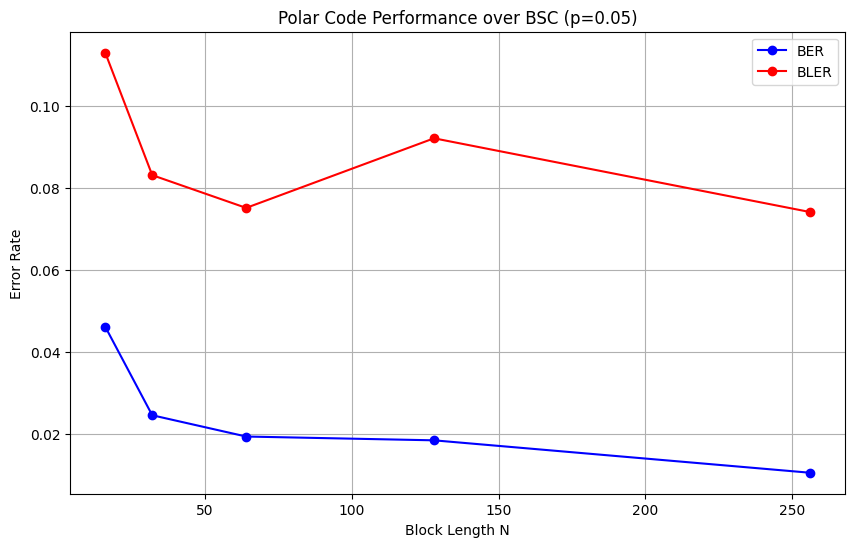

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(N_test_df['N'], N_test_df['BER'], marker='o', color='blue', label='BER')
plt.plot(N_test_df['N'], N_test_df['BLER'], marker='o', color='red', label='BLER')
plt.xlabel('Block Length N')
plt.ylabel('Error Rate')
plt.title('Polar Code Performance over BSC (p=0.05)')
plt.grid(True)
plt.legend()
plt.show()

Testing different noise parameters with fixed N=128 and K=64

In [12]:
noise_test_results = []
ps = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
for p in ps:
    ber, bler = monte_carlo(
        N=128,
        K=64,
        p_channel = p,
        trials=10000,
        use_exact_f=True
    )
    noise_test_results.append({
        'p_channel': p,
        'BER': ber,
        'BLER': bler
    })
noise_test_df = pd.DataFrame(noise_test_results)
display(noise_test_df)

,p_channel,BER,BLER
0,0.01,0.000022,0.0002
1,0.02,0.000389,0.0026
2,0.05,0.016730,0.0887
3,0.10,0.172966,0.6199
4,0.15,0.364869,0.9501
5,0.20,0.448080,0.9977


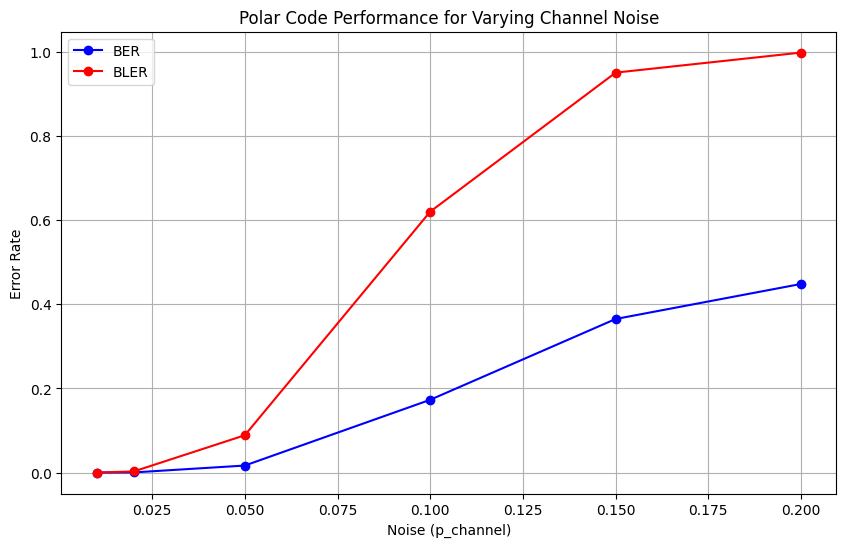

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(noise_test_df['p_channel'], noise_test_df['BER'], marker='o', color='blue', label='BER')
plt.plot(noise_test_df['p_channel'], noise_test_df['BLER'], marker='o', color='red', label='BLER')
plt.xlabel('Noise (p_channel)')
plt.ylabel('Error Rate')
plt.title('Polar Code Performance for Varying Channel Noise')
plt.grid(True)
plt.legend()
plt.show()

Testing K ratios with fixed N=128 and p_channel=0.05

In [14]:
K_test_results = []
K_ratios = [0.25, 0.5, 0.75]
for k in K_ratios:
    ber, bler = monte_carlo(
        N=128,
        K=int(N*k),
        p_channel=0.05,
        trials=10000,
        use_exact_f=True
    )
    K_test_results.append({
        'K Ratio': k,
        'BER': ber,
        'BLER': bler
    })
K_test_df = pd.DataFrame(K_test_results)
display(K_test_df)

,K Ratio,BER,BLER
0,0.25,0.017430,0.0893
1,0.50,0.333514,0.9985
2,0.75,0.333730,0.9986


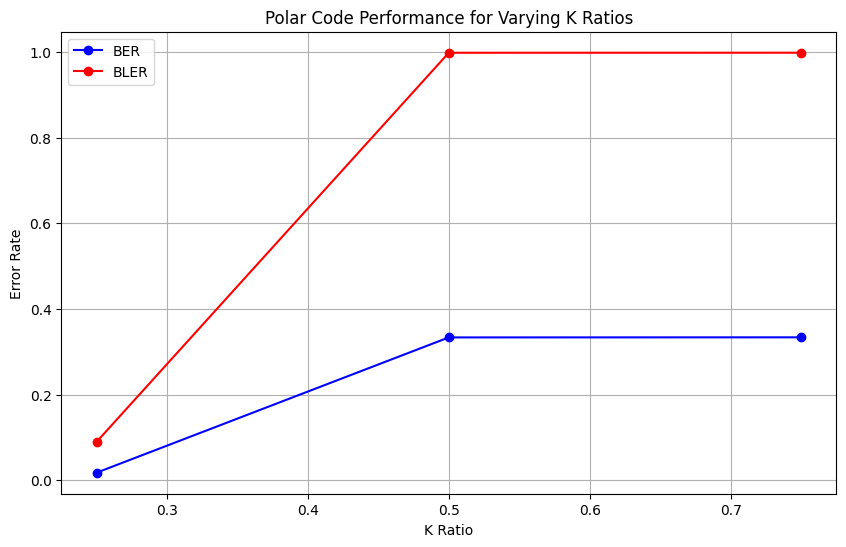

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(K_test_df['K Ratio'], K_test_df['BER'], marker='o', color='blue', label='BER')
plt.plot(K_test_df['K Ratio'], K_test_df['BLER'], marker='o', color='red', label='BLER')
plt.xlabel('K Ratio')
plt.ylabel('Error Rate')
plt.title('Polar Code Performance for Varying K Ratios')
plt.grid(True)
plt.legend()
plt.show()

# Illustration of Channel Polarization

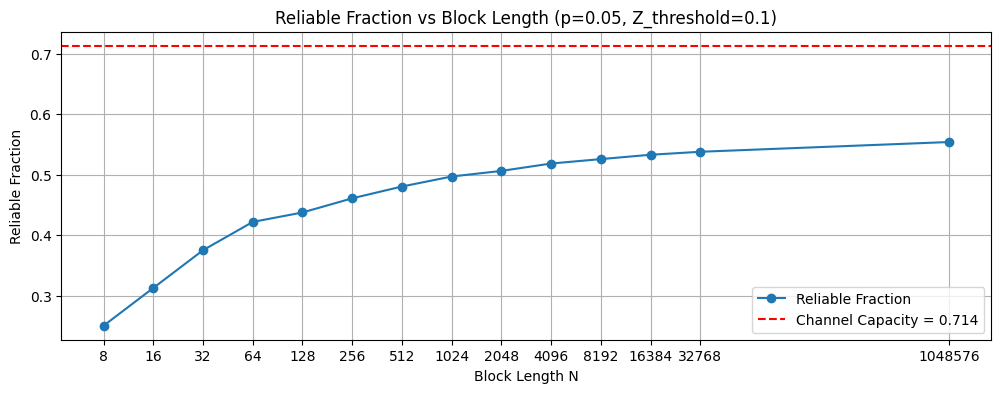

In [32]:
def binary_entropy(p):
    if p <= 0.0 or p >= 1.0:
        return 0.0
    return -(p*np.log2(p) + (1-p)*np.log2(1-p))


def reliable_fraction(N, p, Z_threshold):
    # Computes the reliable fraction of channels for given Bhattacharyya threshold
    Z = bhattacharyya_parameter(p, N)
    reliable_channels = np.sum(Z < Z_threshold)
    return reliable_channels / N


def plot_reliable_fraction(N_list, p, Z_threshold):
    fractions = []
    for N in N_list:
        frac = reliable_fraction(N, p, Z_threshold)
        fractions.append(frac)

    C = 1 - binary_entropy(p)

    plt.figure(figsize=(12,4))
    plt.plot(N_list, fractions, marker='o', label='Reliable Fraction')
    plt.axhline(C, linestyle="--", color='red', label=f'Channel Capacity = {C:.3f}')
    plt.xscale('log', base=2)
    plt.xticks(N_list, N_list)
    plt.xlabel('Block Length N')
    plt.ylabel('Reliable Fraction')
    plt.title(f'Reliable Fraction vs Block Length (p={p}, Z_threshold={Z_threshold})')
    plt.grid(True)
    plt.legend()
    plt.show()


N_list = [8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 1048576]
p = 0.05
Z_threshold = 1e-1
plot_reliable_fraction(N_list, p, Z_threshold)